In [0]:
!pip install kaggle
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [0]:
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d kritika397/breast-cancer-dataset-from-breakhis

breast-cancer-dataset-from-breakhis.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!unzip -q breast-cancer-dataset-from-breakhis.zip

replace fold1/fold1/test/100X/B_100X/SOB_B_A-14-22549G-100-001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense,Reshape
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
from keras.applications import densenet
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
import tensorflow as tf

Using TensorFlow backend.


In [0]:
PATH_TRAIN = "fold1/train/200X"
PATH_TEST = "fold1/test/200X"

In [0]:
import os
print(os.listdir(PATH_TRAIN))
print(os.listdir(PATH_TEST))

import fnmatch,os
Test_M = len(fnmatch.filter(os.listdir(PATH_TEST+'/M_200X'),'*.png'))
print("test_M:  ",Test_M)
Test_B=len(fnmatch.filter(os.listdir(PATH_TEST+"/B_200X"),'*.png'))
print("test_B:   ",Test_B)
total_Test=Test_M+Test_B
print("TEST:  ",total_Test)
Train_M=len(fnmatch.filter(os.listdir(PATH_TRAIN + "/M_200X"),'*.png'))
print("train_M:  ",Train_M)
Train_B=len(fnmatch.filter(os.listdir(PATH_TRAIN + "/B_200X"),'*.png'))
print("train_B:  ",Train_B)
total_train=Train_B+Train_M
print("Train:    ",total_train)

['B_200X', 'M_200X']
['B_200X', 'M_200X']
test_M:   489
test_B:    255
TEST:   744
train_M:   901
train_B:   368
Train:     1269


In [0]:
# Parameters
# 1-3 Hyperparameters
EPOCHS = 100
INIT_LR = 1e-5 # Learning rate
BS = 32

default_image_size = tuple((224,224))
image_size = 0
width=224
height=224
depth=3

In [0]:
train_datagen = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1,rescale = 1./255, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale = 1./255) 


train = train_datagen.flow_from_directory(PATH_TRAIN,
                                            class_mode="categorical",
                                            target_size=(224,224),
                                            color_mode="rgb",
                                            shuffle=True,
                                            batch_size=BS)

print(type(train))

test= test_datagen.flow_from_directory(PATH_TEST,
                                        class_mode="categorical",
                                        target_size=(224,224),
                                        color_mode="rgb",
                                        shuffle=True,
                                        batch_size=BS)
print(type(test))

Found 1269 images belonging to 2 classes.
<class 'keras_preprocessing.image.directory_iterator.DirectoryIterator'>
Found 744 images belonging to 2 classes.
<class 'keras_preprocessing.image.directory_iterator.DirectoryIterator'>


In [0]:
from keras.applications import DenseNet169
dense_conv = DenseNet169(include_top=False, weights='imagenet', input_shape=(224,224,3), classes=2)

model = Sequential()
model.add(dense_conv)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


51879936/51877672 [==============================] - 4s 0us/step


In [0]:
model.summary()
optss = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=optss,metrics=["accuracy"])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 7, 7, 1664)        12642880  
_________________________________________________________________
flatten_2 (Flatten)          (None, 81536)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 81536)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               20873472  
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 33,516,866
Trainable params: 33,358,466
Non-trainable params: 158,400
____________________________________

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpointer = ModelCheckpoint(filepath='weights_{epoch:03d}_{val_acc:.3f}.hdf5', verbose=1, save_best_only=True, monitor="val_loss")
es = EarlyStopping(monitor='val_loss', patience=5)

In [0]:
H = model.fit_generator(
    train,
    steps_per_epoch=total_train // BS,
    validation_data=test,
    validation_steps=total_Test // BS,
    epochs=EPOCHS, callbacks=[checkpointer, es])

Epoch 1/100
39/39 [==============================] - 87s 2s/step - loss: 0.9422 - acc: 0.6603 - val_loss: 0.5352 - val_acc: 0.7568

Epoch 00001: val_loss improved from inf to 0.53524, saving model to weights_001_0.757.hdf5
Epoch 2/100
39/39 [==============================] - 41s 1s/step - loss: 0.6539 - acc: 0.7406 - val_loss: 0.4451 - val_acc: 0.7879

Epoch 00002: val_loss improved from 0.53524 to 0.44507, saving model to weights_002_0.788.hdf5
Epoch 3/100
39/39 [==============================] - 40s 1s/step - loss: 0.4791 - acc: 0.8028 - val_loss: 0.3945 - val_acc: 0.8258

Epoch 00003: val_loss improved from 0.44507 to 0.39453, saving model to weights_003_0.826.hdf5
Epoch 4/100
39/39 [==============================] - 40s 1s/step - loss: 0.4089 - acc: 0.8229 - val_loss: 0.3698 - val_acc: 0.8287

Epoch 00004: val_loss improved from 0.39453 to 0.36983, saving model to weights_004_0.829.hdf5
Epoch 5/100
39/39 [==============================] - 41s 1s/step - loss: 0.3595 - acc: 0.8566 - 

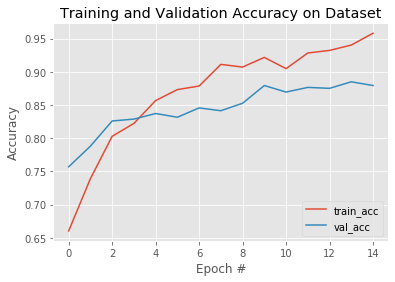

In [0]:
N = 15
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training and Validation Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig('Accuracy.png')

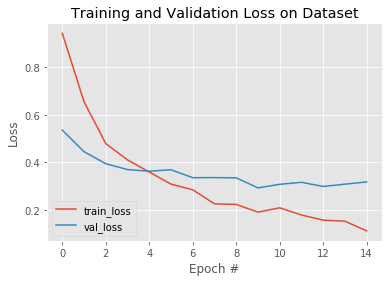

In [0]:
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig('Loss.png')

In [0]:
# validation

test.reset()
pred = model.evaluate_generator(generator=test,
steps=total_Test // BS,
verbose=1)

23/23 [==============================] - 11s 470ms/step


In [0]:
# import the necessary packages
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import numpy as np
import imutils
import cv2

In [0]:
# load the trained convolutional neural network
MODELNAME = 'weights_010_0.879.hdf5'
PATH_TEST = "fold1/test/200X"

model = load_model(MODELNAME)

KeyboardInterrupt: ignored

In [0]:
test_datagen = ImageDataGenerator(rescale = 1./255) 


test = train_datagen.flow_from_directory(PATH_TEST,
                                            class_mode="categorical",
                                            target_size=(224, 224),
                                            color_mode="rgb",
                                            shuffle=False,
                                            batch_size=BS)

Found 744 images belonging to 2 classes.


In [0]:
# evaluate the model
test.reset()
_, test_acc = model.evaluate_generator(generator=test,
                              verbose=1)
test_acc

24/24 [==============================] - 28s 1s/step


0.9032258064516129

In [0]:
test.reset()

pred_test = model.predict_generator(test, verbose=1)

24/24 [==============================] - 20s 844ms/step


In [0]:
test_pred_labels = np.argmax(pred_test,axis=1)
test_pred_labels

array([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(test.labels, test_pred_labels)

0.885752688172043

In [0]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(test.labels, test_pred_labels)

(array([0.85123967, 0.90239044]),
 array([0.80784314, 0.92638037]),
 array([0.82897384, 0.91422805]),
 array([255, 489]))

In [0]:
from sklearn.metrics import f1_score
f1_score(test.labels, test_pred_labels)

0.9142280524722501

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test.labels, test_pred_labels)
cm

array([[206,  49],
       [ 36, 453]])

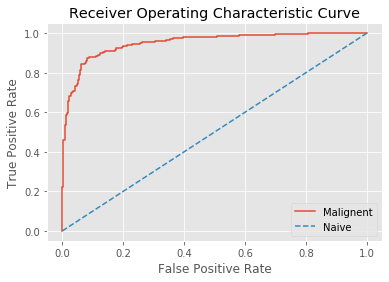

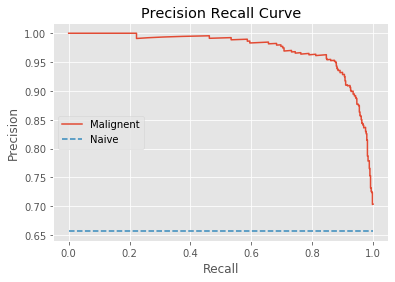

In [0]:
from sklearn.metrics import roc_curve, precision_recall_curve
lr_probs = pred_test[:, 1]
fpr, tpr, thresholds = roc_curve(test.labels, lr_probs)

plt.figure()
plt.plot(fpr, tpr, label="Malignent")
plt.plot([0,1],[0,1], linestyle='--', label='Naive')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()


fpr, tpr, thresholds = precision_recall_curve(test.labels, lr_probs)
plt.figure()
plt.plot(tpr, fpr, label="Malignent")
naive = len(test.labels[test.labels==1]) / len(test.labels)
plt.plot([0,1],[naive,naive], linestyle='--', label='Naive')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend()
plt.show()

In [0]:
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
specificity

0.9263803680981595

In [0]:
sensisitivity = cm[0,0]/(cm[0,0]+cm[0,1])
sensisitivity

0.807843137254902

In [0]:
precision = cm[0,0]/(cm[0,0]+cm[1,0])
precision

0.8512396694214877